Noms et prénoms des membres du groupe:

-

### Exécuter la cellule suivante afin de charger l'ensemble des outils et fonctions nécessaires

In [2]:
from IPython.core.display import HTML
from functools import partial
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib notebook
#%matplotlib inline
import pip
pip.main('install imageio'.split())
import imageio
import skimage.morphology
import skimage.segmentation
import skimage.feature
import skimage.data
import cv2

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.max_open_warning'] = 100
plt.rcParams['figure.figsize'] = 2, 2

def format_coord(x, y, image):
    x = int(x + 0.5)
    y = int(y + 0.5)
    try:
        val = str(image[y, x])
    except IndexError:
        val = "?"
    return "color={} @ [{}, {}]".format(val, y, x)

def display_image_nb(image, title='', cmap=None):
    fig, ax = plt.subplots(1,1)
    if cmap is None:
        ax.matshow(image)
    else:
        ax.matshow(image, cmap=cmap)
    ax.set_xlabel(title)
    ax.format_coord = partial(format_coord, image=image)
    #return fig, ax

def display_image_color(image, title=''):
    fig, ax = plt.subplots(1,1)
    ax.imshow(image)
    ax.set_xlabel(title)
    ax.format_coord = partial(format_coord, image=image)
    #return fig, ax

def display_image_color_opencv(image, title=''):
    fig, ax = plt.subplots(1,1)
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_xlabel(title)
    ax.format_coord = partial(format_coord, image=image)
    
def draw_rectangle(y1, x1, y2, x2, color='red', ax=None, alpha=1):
    """ Add a rectangle on an image """
    if ax is None:
        ax = plt.gca()
    rect = mpatches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                              fill=False, edgecolor=color, linewidth=2, alpha=alpha)
    ax.add_patch(rect)

print("OK let's go")


OK let's go


# Exercice 1: Trouver les différences

Compléter le code suivant afin de trouver les différences entre les deux images img_nb_1, img_nb_2


<IPython.core.display.Javascript object>


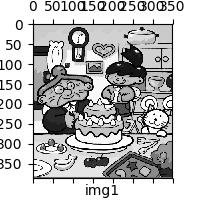

<IPython.core.display.Javascript object>


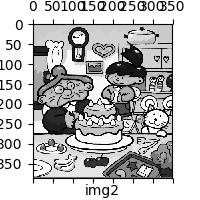

In [2]:
# chargement des images
img_nb_1 = imageio.imread('http://srand.fr/data/spot_diff_1.png')
img_nb_2 = imageio.imread('http://srand.fr/data/spot_diff_2.png')
display_image_nb(img_nb_1, title='img1')
display_image_nb(img_nb_2, title='img2')


- Calculer la différence entre **img_nb_1** et **img_nb_2**:

In [ ]:
img_diff =

- Afficher l'image des différences

- Calculer le masque binaire correspondant aux positions où une différence a été détectée (le masque doit valoir **True** là où une différence a été détectée)
- Afficher ce masque

In [ ]:
mask = 

# afficher le masque : 



- Utiliser une opération morphologique afin de regrouper les régions du masque ayant des valeurs à True (i.e il s'agit ici d'enlever les trous dans les zones blanches)

In [ ]:
import skimage.morphology

new_mask = 

Afficher l'image original, et dessiner un rectange autour des zones dans lesquelles il y a eu une différence.

Aide: le code est quasiment similaire à celui du tp1 (cellule 31: http://srand.fr/cours/tp1_red_ball_detection-Correction_one_page.html )

- Combien de différences présentent les deux images

# Exercice 2: Détection de chat

Utiliser le détecteur d'opencv cv2.CascadeClassifier avec le jeux d'apprentissage /root/anaconda3/share/OpenCV/haarcascades/haarcascade_frontalcatface_extended.xml

afin de détecter le chat dans l'image suivante

<IPython.core.display.Javascript object>


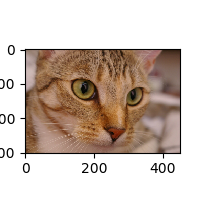

In [10]:
import skimage.data
img = skimage.data.chelsea()
display_image_color(img)

<IPython.core.display.Javascript object>


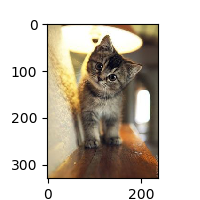

In [18]:
img = imageio.imread('/data/cat.jpg')
display_image_color(img)

<IPython.core.display.Javascript object>


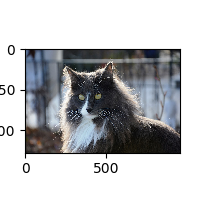

In [25]:
img = imageio.imread('/data/out.jpg')
display_image_color(img)

<IPython.core.display.Javascript object>


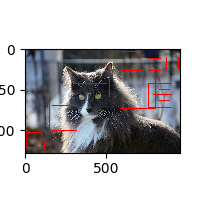

In [32]:
cat_cascade = cv2.CascadeClassifier("/root/anaconda3/share/OpenCV/haarcascades/haarcascade_frontalcatface_extended.xml")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = cat_cascade.detectMultiScale(gray)
for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]


display_image_color(img)

In [29]:
!wget https://s-media-cache-ak0.pinimg.com/236x/00/ca/f9/00caf9518e253e7adc8997aff8acaad4.jpg /data/out.jpg

converted 'https://s-media-cache-ak0.pinimg.com/236x/00/ca/f9/00caf9518e253e7adc8997aff8acaad4.jpg' (ANSI_X3.4-1968) -> 'https://s-media-cache-ak0.pinimg.com/236x/00/ca/f9/00caf9518e253e7adc8997aff8acaad4.jpg' (UTF-8)
--2017-03-08 13:30:22--  https://s-media-cache-ak0.pinimg.com/236x/00/ca/f9/00caf9518e253e7adc8997aff8acaad4.jpg
Resolving s-media-cache-ak0.pinimg.com (s-media-cache-ak0.pinimg.com)... 151.101.120.84, 2a04:4e42:1d::84
Connecting to s-media-cache-ak0.pinimg.com (s-media-cache-ak0.pinimg.com)|151.101.120.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13770 (13K) [image/jpeg]
Saving to: '00caf9518e253e7adc8997aff8acaad4.jpg'

00caf9518e253e7adc8 100%[=====================>]  13.45K  61.5KB/s   in 0.2s   

2017-03-08 13:30:23 (61.5 KB/s) - '00caf9518e253e7adc8997aff8acaad4.jpg' saved [13770/13770]

/data/out.jpg: Scheme missing.
FINISHED --2017-03-08 13:30:23--
Total wall clock time: 0.3s
Downloaded: 1 files, 13K in 0.2s (61.5 KB/s)


<IPython.core.display.Javascript object>


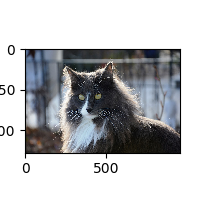

In [33]:
img = imageio.imread('/data/out.jpg')
display_image_color(img)

# Exercice 3: Où est charlie ?



<IPython.core.display.Javascript object>


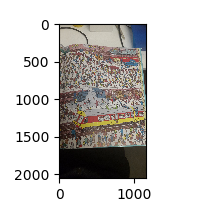

In [3]:
scene_image = cv2.imread("/images/waldo1.jpg")
display_image_color_opencv(scene_image)

<IPython.core.display.Javascript object>


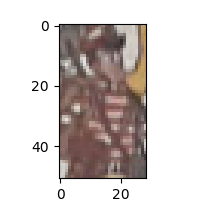

In [5]:
obj_image = cv2.imread("/images/waldo_obj.png")
display_image_color_opencv(obj_image)

Utilisez les méthodes opencv suivante afin de trouver Charlie (i.e l'image obj_image) dans l'image scene_image:

    - cv2.minMaxLoc (cf doc opencv)
    - cv2.MatchTemplate (cf doc opencv + google)


Utilisez les méthodes suivantes afin de faire ressortir la partie de l'image contenant charlie que vous avez trouvé à la question précédente:

    - cv2.addWeighted (cf doc opencv)
    - les mask numpy (cf tp1)

# Exercice 4: Détection de véhicules

Dans cet exercice vous utiliserez des méthodes de machine learning afin de détecter la présence de véhicules dans des images.



Exemple de détection obtenu en faisant cet exercice: 
![alt text](http://srand.fr/data/car_detected.png "Car detected")

## Téléchargement des données pour l'apprentissage

Vous utiliserez les images disponnibles dans /images/CarData/TrainImages et  /images/CarData/TestImages 

Le fichier README.txt dans le répertoire CarData décrit le contenu de l'archive: 

[...]

1. Training images
These are located in CarData/TrainImages/. The positive (car) images are named pos-n.pgm (0 <= n <= 549). The negative (non-car) images are named similarly as neg-n.pgm (0 <= n <= 499).
The training images are all 100x40 pixels in size.

[...]


Afficher les 2 première images (une image negative et une image positive) de la base de donnée d'apprentissage


<IPython.core.display.Javascript object>


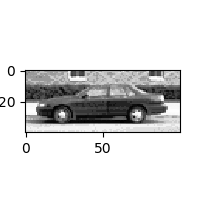

In [4]:
img1 = imageio.imread('/images/CarData/TrainImages/pos-0.pgm')
display_image_color(img1)

- Le code suivant permet d'ouvrir les différentes images (positives et négatives) et de les stocker dans des listes (images_positives et images_negatives)

In [13]:
import glob
path = './CarData/TrainImages/'
negative_files = glob.glob(path + 'neg-*.pgm')
positive_files = glob.glob(path + 'pos-*.pgm')
images_positives = [imageio.imread(positive_file) for positive_file in positive_files]
images_negatives = [imageio.imread(negative_file) for negative_file in negative_files]

<IPython.core.display.Javascript object>


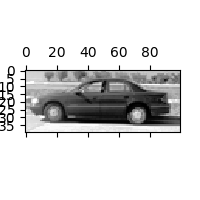

In [14]:
# Affichage de la première image positive
display_image_nb(images_positives[0])

<IPython.core.display.Javascript object>


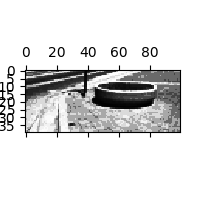

In [15]:
# Affichage de la 5 ème image negative
display_image_nb(images_negatives[4])

- À quoi correspondent les images "positives" ? 
- À quoi correspondent les images "negatives" ? 
- Combien d'images avons nous dans chaque classe ?
- Quelle est la taille de chaque image ?

## Apprentissage

De façon à pré-traité les images, et à extraire un vecteur de caractéristiques décrivant le contenu de chaque image nous utiliserons la fonction suivante. Elle calcule des "local_binary_pattern" pour chaque image (comme vu lors du tp 3).

In [16]:
from skimage.feature import local_binary_pattern

def compute_feature_vect(image, debug=False):
    radius = 2
    n_points = 8 * radius
    METHOD = 'uniform'
    lbp = local_binary_pattern(image, n_points, radius, METHOD)
    n_bins = 18
    hists = []
    if debug:
        display_image_nb(image)
    I = image.shape[0] / 6
    J = image.shape[1] / 5
    step = 10
    #tab = skimage.util.view_as_blocks(lbp, (I, J))
    tab = skimage.util.view_as_windows(lbp, (I,J), step=step)
    c = 0
    colors = ['blue', 'green', 'red']
    for i in range(tab.shape[0]):
        for j in range(tab.shape[1]):
            c+=1
            sub = tab[i, j]
            hist, _ = np.histogram(sub, normed=True, bins=n_bins, range=(0, n_bins))
            hists.append(hist.flatten())
            if debug:
                draw_rectangle(i*step, j*step, i*step+I-1, j*step+J-1, color=colors[c%len(colors)], alpha=0.8)
    return np.array(hists).flatten()

Afin de pouvoir utiliser les outils d'apprentissages automatisés, les données doivent être mise au format suivant:

    - X = data  (un vecteur avec tous les images pré-traités)
    - Y = label (un vecteur avec les labels associés à chaque image)

Nous utiliserons le label **"negative"** pour les images de la classe negative, et le label **"positive"** pour les images de la classe positive.


**Compléter le code suivant:**

In [ ]:
X = []
Y = []

for image in images_negatives:
    X.append(compute_feature_vect(image))
    Y.append(          )
    
for image in images_positives:
    X.append(compute_feature_vect(image))
    Y.append(         )
    

In [ ]:
print(Y)

Entrainer un classifieur de type K-nearest neighbors (en utilisant 10 voisins).
A l'aide de la fonction cross_val_score, calculer les pourcentages d'accuracy obtenus sur le jeu d'entrainement.

- Que pouvez vous dire sur ces pourcentages ? 
- Quel serait l'accuracy d'un classifieur aléatoire sur ce jeu de donnée ? (Utiliser un DummyClassifier pour vérifier)



In [ ]:
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score



clf_k_nearest_neighbors =  
scores_cross_validation = 

print(scores_cross_validation)

In [ ]:
from sklearn.dummy import DummyClassifier
classifieur_tout_pourri = 
scores_cross_validation = 
print(scores_cross_validation)


Entrainer un classifieur de type AdaBoost (en utilisant 200 estimateurs (n_estimators=200)).
A l'aide de la fonction cross_val_score, calculer les pourcentages d'accuracy obtenus avec ce classifieur sur le jeu d'entrainement.

Comparer ces résultats aux résultats obtenus avec le classifieur de type K-nearest neighbors.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
clf_adaboost = AdaBoostClassifier(                 )
scores_cross_validation = 
print(scores_cross_validation)


Dans la suite nous utiliserons le classifieur *clf_adaboost*.

Lancer l'apprentissage pour ce classifieur (méthode fit)

In [ ]:
clf_adaboost.




# Reconnaissance d'un véhicule

Nous diposons à présent d'un classifieur de type AdaBoost qui sait prédire la présence d'un véhicule dans une image de 40x100 pixels.

Tester ce classifieur sur la première image posivite, et sur la 5 ème image negative.

** N'oubliez pas d'utiliser la méthode compute_feature_vect afin de prétraiter les images **

In [ ]:
image_test1 = images_positives[0]
display_image_nb(image_test1)
prediction_image_test_1 = clf_adaboost.     # a completer        
print(prediction_image_test_1)


image_test2 = images_negatives[4]
display_image_nb(image_test2)
prediction_image_test_2 = clf_adaboost.     # a completer        
print(prediction_image_test_2)


# Détection d'un véhicule dans une image

Nous nous interessons ici à la détection d'une véhicule dans une image plus grande que 40x100 pixels. Afin de détecter un véhicule nous utiliserons une fenêtre glissante comme vu lors du tp3. La fonction suivante vous permet d'utiliser une fenêtre glissante.

In [18]:
def check_image(image_test, window_size = (40, 100), clf=None, compute_feat_function=None):
    """
    image_test: image en entree
    window_size: taille de la fenetre glissante (correspond a la taille des images dans l'ensemble d'apprentissage)
    clf: votre classifieur deja entrainé
    compute_feature_vect: la fonction de pré-traitement des images
    """
    STEP = max(window_size) /5
    tab = skimage.util.view_as_windows(image_test, window_size, STEP)
    display_image_nb(image_test)
    for i in range(tab.shape[0]):
        for j in range(tab.shape[1]):
            block = tab[i, j]
            if compute_feat_function is not None:
                block = compute_feat_function(block)
            prediction = clf.predict(block.flatten())
            #print(prediction)
            if prediction == 'positive':
                draw_rectangle(i*STEP, j*STEP, i*STEP+window_size[0], j*STEP+window_size[1], color='green')


<IPython.core.display.Javascript object>


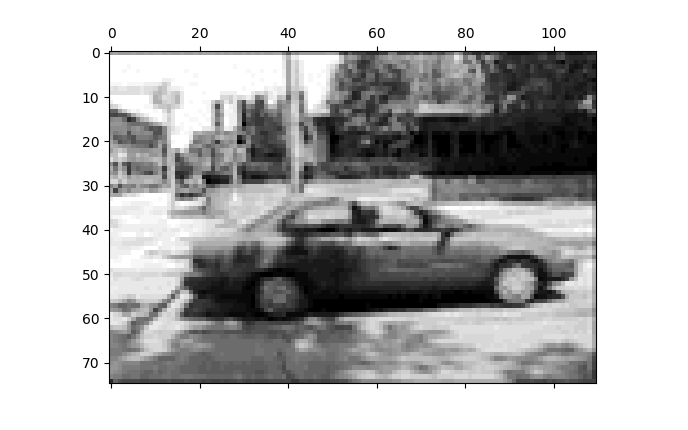

In [20]:
# Exemple d'utilisation
im1 = imageio.imread('http://srand.fr/data/test-43.pgm')
display_image_nb(im1)
#check_image(im1, window_size=(40, 100), clf=clf_adaboost, compute_feat_function=compute_feature_vect)

Testez le classifieur à l'aide de la méthode check_image sur 10 images du dossier CarData/TestImages/  (afficher les 10 résultats)

Vous pouvez utiliser la méthode glob.glob ainsi qu'une boucle, ou utiliser le chemin complet vers les images.

# Fin

Merci d'envoyer votre tp à Laurent.f.george@ gmail. com.

(File->print_preview, puis enregistrer_sous).